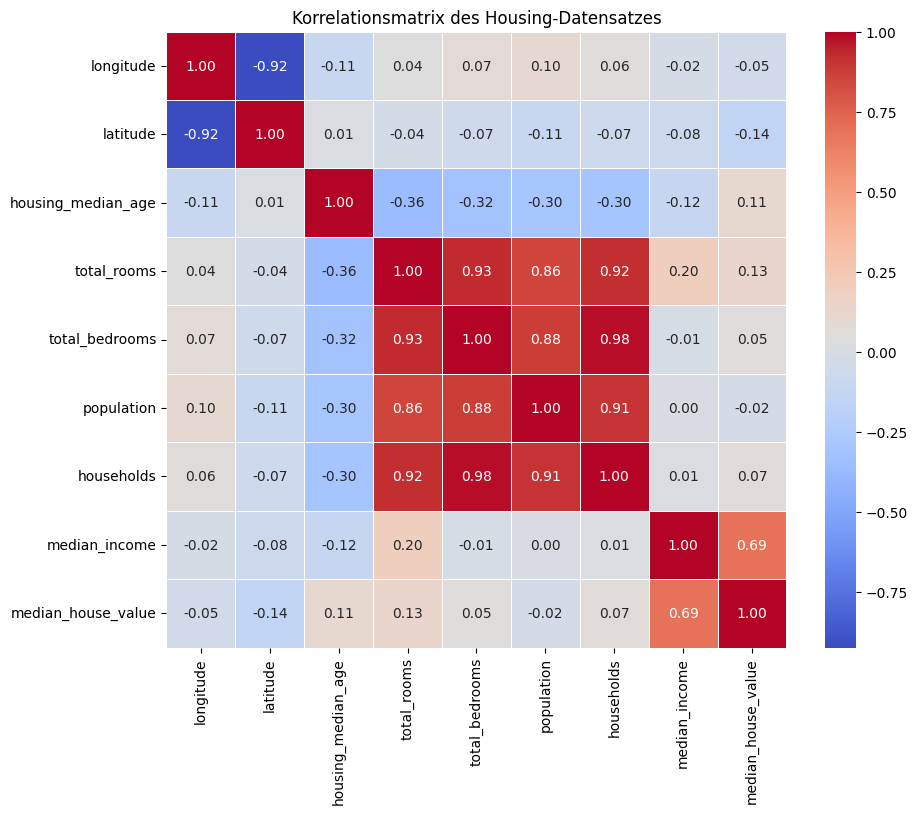

In [25]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

housing = pd.read_csv("housing.csv")
corr = housing.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korrelationsmatrix des Housing-Datensatzes')
plt.show()


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

housing = pd.read_csv("housing.csv")
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]
X_numeric = X.select_dtypes(include=[np.number])

def evaluate(drop_cols):
    cols = [c for c in X_numeric.columns if c not in drop_cols]
    X_sub = X_numeric[cols]
    X_train_num, X_test_num, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, random_state=42)
    imputer = SimpleImputer(strategy="mean")
    X_train_imp = imputer.fit_transform(X_train_num)
    X_test_imp = imputer.transform(X_test_num)

    # SelectKBest -> LinearRegression
    k = min(5, X_train_imp.shape[1])
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_train_imp, y_train)
    sel_mask = selector.get_support()
    sel_features = list(X_train_num.columns[sel_mask])
    X_train_kbest = X_train_imp[:, sel_mask]
    X_test_kbest = X_test_imp[:, sel_mask]
    model_k = LinearRegression().fit(X_train_kbest, y_train)
    y_k_pred = model_k.predict(X_test_kbest)
    rmse_k = np.sqrt(mean_squared_error(y_test, y_k_pred))

    # RandomForest -> Feature importances -> top-k -> LinearRegression
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train_imp, y_train)
    importances = pd.Series(rf.feature_importances_, index=X_train_num.columns).sort_values(ascending=False)
    top_features = list(importances.head(k).index)
    top_mask = [col in top_features for col in X_train_num.columns]
    X_train_top = X_train_imp[:, top_mask]
    X_test_top = X_test_imp[:, top_mask]
    model_r = LinearRegression().fit(X_train_top, y_train)
    y_r_pred = model_r.predict(X_test_top)
    rmse_r = np.sqrt(mean_squared_error(y_test, y_r_pred))

    return {
        "dropped": drop_cols,
        "sel_features": sel_features,
        "top_features": top_features,
        "rmse_kbest": rmse_k,
        "rmse_rf": rmse_r
    }

variants = [
    [],                      # baseline
    ["households"],          # drop households
    ["population"],          # drop population
    ["total_rooms"],         # drop total_rooms
    ["latitude"],            # drop latitude
    ["longitude"]            # drop longitude
]

results = [evaluate(v) for v in variants]
df = pd.DataFrame([{
    "dropped": ",".join(r["dropped"]) or "none",
    "sel_features": ", ".join(r["sel_features"]),
    "top_features": ", ".join(r["top_features"]),
    "rmse_SelectKBest_LR": r["rmse_kbest"],
    "rmse_RFtop_LR": r["rmse_rf"]
} for r in results])

print(df.to_string(index=False))

    dropped                                                               sel_features                                                             top_features  rmse_SelectKBest_LR  rmse_RFtop_LR
       none       latitude, housing_median_age, total_rooms, households, median_income       median_income, longitude, latitude, housing_median_age, population         78633.208097   74088.438650
 households   latitude, housing_median_age, total_rooms, total_bedrooms, median_income       median_income, longitude, latitude, housing_median_age, population         79245.105771   74088.438650
 population       latitude, housing_median_age, total_rooms, households, median_income      median_income, longitude, latitude, housing_median_age, total_rooms         78633.208097   73793.096814
total_rooms    latitude, housing_median_age, total_bedrooms, households, median_income       median_income, longitude, latitude, housing_median_age, population         79813.828675   74088.438650
   latitude housing_

CV RMSE (5-fold): mean=69236.33, std=8622.83
Test RMSE: 49499.52


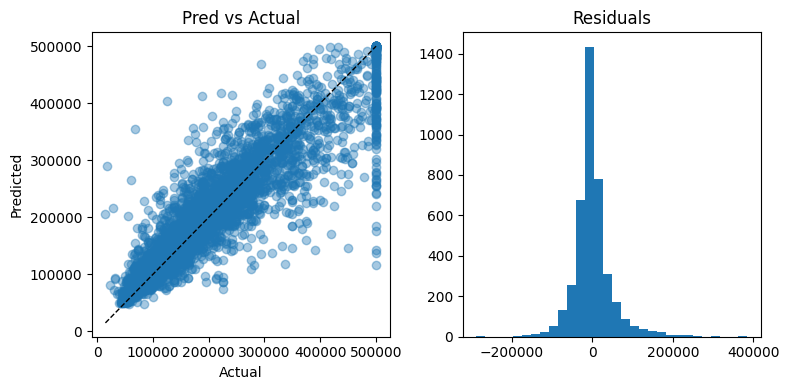

Top 10 Feature Importances:
 median_income               0.481185
ocean_proximity_INLAND      0.138438
population_per_household    0.120916
longitude                   0.057680
latitude                    0.056493
housing_median_age          0.044269
rooms_per_household         0.025963
bedrooms_per_room           0.024478
total_rooms                 0.012750
total_bedrooms              0.011962


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Lade Daten und erstelle einfache Feature-Engineering-Features
housing = pd.read_csv("housing.csv")
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

# Ziel / Merkmale
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

# Spaltenlisten
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]

# Preprocessing-Pipes
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", cat_transformer, categorical_cols)
])

# Modell-Pipeline
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

# Cross-Validation (5-fold) RMSE
scores = cross_val_score(pipeline, X, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
rmse_cv = np.sqrt(-scores)
print("CV RMSE (5-fold): mean={:.2f}, std={:.2f}".format(rmse_cv.mean(), rmse_cv.std()))

# Train/Test-Fit für finalen Test RMSE und Residuenanalyse
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", round(rmse_test, 2))

# Kurze Residual-Check (optional)
import matplotlib.pyplot as plt
res = y_test - y_pred
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'k--',linewidth=1)
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Pred vs Actual")
plt.subplot(1,2,2)
plt.hist(res, bins=30)
plt.title("Residuals")
plt.tight_layout()
plt.show()

# (Optional) Feature-Importances anzeigen — falls sklearn-Version get_feature_names_out unterstützt
try:
    num_names = numeric_cols
    cat_names = pipeline.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
    feature_names = num_names + cat_names
    importances = pipeline.named_steps['model'].feature_importances_
    imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("Top 10 Feature Importances:\n", imp_series.head(10).to_string())
except Exception:
    pass

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

# Lade Daten + simples Feature-Engineering (falls noch nicht vorhanden)
housing = pd.read_csv("housing.csv")
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

# Spaltenlisten
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]

# Preprocessor (Num + Cat)
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", cat_transformer, categorical_cols)
])

# Modelle + Grid (verwende 'model__' Prefix für Pipeline-Param)
models_and_grids = {
    "LinearRegression": (
        LinearRegression(),
        {"model__fit_intercept": [True, False]}
    ),
    "Ridge": (
        Ridge(),
        {"model__alpha": [0.1, 1.0, 10.0]}
    ),
    "SVR": (
        SVR(),
        {"model__C": [1, 10], "model__kernel": ["rbf", "linear"], "model__gamma": ["scale"]}
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=42),
        {"model__max_depth": [5, 10, None], "model__min_samples_leaf": [1, 5]}
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {"model__n_estimators": [100, 200], "model__max_depth": [10, None]}
    ),
    "XGBoost": (
        XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1),
        {"model__n_estimators": [100, 200], "model__max_depth": [3, 6], "model__learning_rate": [0.05, 0.1]}
    ),
    "LightGBM": (
        LGBMRegressor(random_state=42, n_jobs=-1),
        {"model__n_estimators": [100, 200], "model__max_depth": [-1, 10], "model__learning_rate": [0.05, 0.1]}
    ),
    "CatBoost": (
        CatBoostRegressor(silent=True, random_state=42),
        {"model__iterations": [100, 200], "model__depth": [4, 6], "model__learning_rate": [0.05, 0.1]}
    )
}

# Hold-out für finalen Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
for name, (estimator, grid) in models_and_grids.items():
    pipe = Pipeline([("preproc", preprocessor), ("model", estimator)])
    gs = GridSearchCV(pipe, param_grid=grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    gs.fit(X_train, y_train)
    # CV-RMSE (aus best_score_)
    cv_rmse = np.sqrt(-gs.best_score_)
    best_params = gs.best_params_
    # Test-RMSE auf Hold-out
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({
        "model": name,
        "cv_rmse": cv_rmse,
        "test_rmse": test_rmse,
        "best_params": best_params
    })

res_df = pd.DataFrame(results).sort_values("cv_rmse")
print(res_df.to_string(index=False))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 15
[LightGBM] [Info] Start training from score 207163.052006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2611
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 15
[LightGBM] [Info] Start training from score 207004.952385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 15
[LightGBM] [Info]